In [14]:
from collections import defaultdict
import numpy as np
from gridworld import GridWorld

In [15]:
env = GridWorld()
action = 0 #더미 행동
next_state, reward, done = env.step(action) # 행동 수행

In [16]:
print("next_state : ", next_state)
print("reward : ", reward)
print("done : ", done)

next_state :  (1, 0)
reward :  0
done :  False


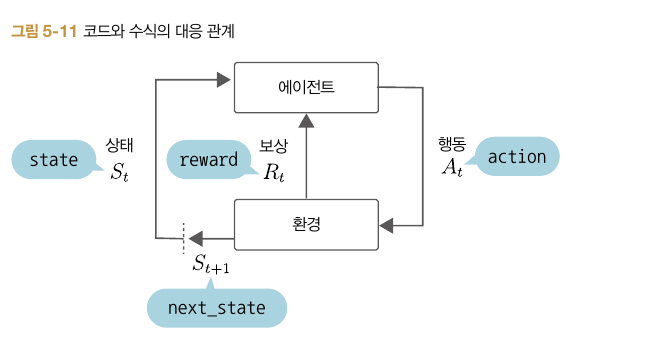

In [17]:
state = env.reset()

# mc_eval

In [18]:
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):  # 역방향으로(reserved) 따라가기
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]


* random_actions : 무작위 행동 할 확률분포

* pi : policy

* V : state value func

* memory : 실제 행동하여 얻은 경험 (state, action, reward)

* cnts : 증분

In [19]:
env = GridWorld()
agent = RandomAgent()

In [20]:
episodes = 1000
for episode in range(episodes):  # 에피소드 1000번 수행
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)             # 행동 선택
        next_state, reward, done = env.step(action)  # 행동 수행

        agent.add(state, action, reward)  # (상태, 행동, 보상) 저장
        if done:   # 목표에 도달 시
            agent.eval()  # 몬테카를로법으로 가치 함수 갱신
            break         # 다음 에피소드 시작

        state = next_state

- 에이전트가 먼저 행동 
- 그 결과로 얻은 state, action, reward 기록 
- 목표 도달시 얻은 샘플데이터로 MC 적용해 가치함수 갱신
</br></br>
* 무작위 정책이기에 어떤 위치든 경유 가능
* 모든 state 에서의 가치함수 평가 가능

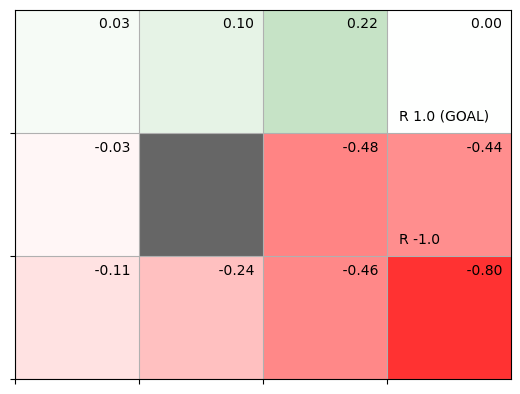

In [21]:
# [그림 5-12] 몬테카를로법으로 얻은 가치 함수
env.render_v(agent.V)

# MC_control
- $\epsilon$ greedy 사용
- 고정값 $\alpha$ 방식 사용

In [22]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [23]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1  # (첫 번째 개선) ε-탐욕 정책의 ε
        self.alpha = 0.1    # (두 번째 개선) Q 함수 갱신 시의 고정값 α
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        # self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            # self.cnts[key] += 1
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key]
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


In [24]:
env = GridWorld()
agent = McAgent()

In [25]:
episodes = 10000

In [26]:
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

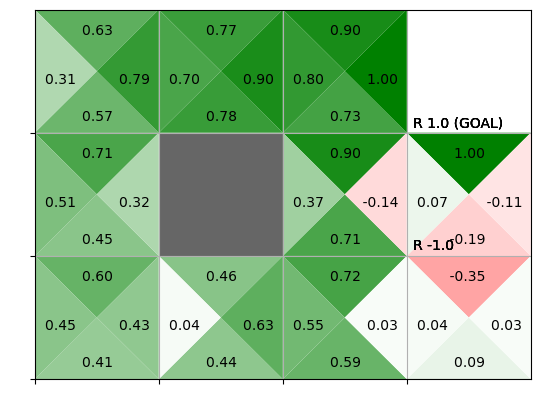

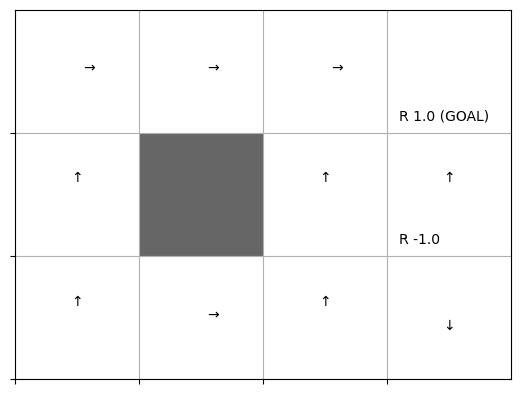

In [27]:
# [그림 5-17] 및 [그림 5-18]
env.render_q(agent.Q)

# importance sampling

In [28]:
x = np.array([1, 2, 3])         # 확률 변수
pi = np.array([0.1, 0.1, 0.8])  # 확률 분포

In [29]:
# =========== 기댓값의 참값 계산 ==================
e = np.sum(x * pi)
print('참값(E_pi[x]):', e)

참값(E_pi[x]): 2.7


In [30]:
# =========== 몬테카를로법으로 계산 ==================
n = 100  # 샘플 개수
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)  # pi를 이용한 샘플링
    samples.append(s)

In [31]:
mean = np.mean(samples)  # 샘플들의 평균
var = np.var(samples)    # 샘플들의 분산
print('몬테카를로법: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

몬테카를로법: 2.55 (분산: 0.57)


In [34]:
# =========== 중요도 샘플링으로 계산 ===========
b = np.array([1/3, 1/3, 1/3]) #b = np.array([0.2, 0.2, 0.6]) 
samples = []
for _ in range(n):
    idx = np.arange(len(b))         # b의 인덱스([0, 1, 2])
    i = np.random.choice(idx, p=b)  # b를 사용하여 샘플링
    s = x[i]
    rho = pi[i] / b[i]              # 가중치
    samples.append(rho * s)         # 샘플 데이터에 가중치를 곱해 저장

In [35]:
mean = np.mean(samples)
var = np.var(samples)
print('중요도 샘플링: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

중요도 샘플링: 2.88 (분산: 10.51)


In [32]:
# =========== 중요도 샘플링으로 계산 ===========
b = np.array([0.2, 0.2, 0.6])  #b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))         # b의 인덱스([0, 1, 2])
    i = np.random.choice(idx, p=b)  # b를 사용하여 샘플링
    s = x[i]
    rho = pi[i] / b[i]              # 가중치
    samples.append(rho * s)         # 샘플 데이터에 가중치를 곱해 저장

In [33]:
mean = np.mean(samples)
var = np.var(samples)
print('중요도 샘플링: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

중요도 샘플링: 2.77 (분산: 2.49)
